<a href="https://colab.research.google.com/github/tumanov-a/home_bro/blob/main/type_photo_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from math import ceil

import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_hub as hub
import os
import albumentations as A
import splitfolders

from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from ImageDataAugmentor.image_data_augmentor import *

%matplotlib inline

In [2]:
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-__xnf645
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-__xnf645
     |████████████████████████████████| 49.5MB 65kB/s 
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-cp36-none-any.whl size=28176 sha256=9265c7cd2b07a5798bba070ada5920baf73a1ea75ab83b93372a3e6298e74637
  Stored in directory: /tmp/pip-ephem-wheel-cache-75qq0xm5/wheels/d9/10/55/6fca35a4072f87d694876d56ece64db3846cf45e1da1c381fe
Successfully built ImageDataAugmentor
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [3]:
!pip install split-folders

In [5]:
home_dir = '../content/drive/MyDrive/homebro'

for main_dir in os.listdir(home_dir):
        directory = os.path.join(home_dir, main_dir)
        for k, img_url in enumerate(os.listdir(directory)):
            img_url = os.path.join(directory, img_url)
            if k > 868:
                os.remove(img_url)

In [6]:
image_labels = os.listdir(home_dir)

In [7]:
splitfolders.ratio(home_dir, output='/content/sample_data', seed=1337, ratio=(0.7, 0.15, 0.15))

Copying files: 4345 files [40:04,  1.81 files/s]


In [8]:
dirs = os.listdir('/content/sample_data/')
shapes = dict()
for dir in ['test', 'train', 'val']:
  dir_1 = os.path.join('/content/sample_data/', dir)
  len_path = 0
  if os.path.isdir(dir_1):
    for dir_2 in os.listdir(dir_1):
      len_path += len(os.listdir(os.path.join(dir_1, dir_2)))
    shapes[dir] = len_path

In [9]:
def transform(image):
    h, w, _ = image.shape
    hcr = random.randint(10, 13) / 10
    wcr = random.randint(10, 13) / 10
    t = A.Compose([
        A.CLAHE(),
        A.RandomBrightness(limit=0.1),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1),
        A.RandomGamma(gamma_limit=(80,120)),
        A.Blur(blur_limit=3),
        A.OpticalDistortion(distort_limit=0.05),
        A.GridDistortion(distort_limit=0.06),
        A.HueSaturationValue(hue_shift_limit=2),
        A.RandomScale(scale_limit=0.5),
        A.RandomCrop(int(h / hcr), int(w / wcr), p=0.3),
    ])
    return t(image=image)['image']

In [10]:
image_gen = ImageDataAugmentor(rescale=1./255, augment=transform)

In [11]:
train_size = shapes['train']
val_size = shapes['val']
test_size = shapes['test']

In [9]:
image_gen = ImageDataGenerator(
    rescale=1./255,
    )

In [12]:
train_dir = os.path.join('/content/sample_data/', 'train')
test_dir = os.path.join('/content/sample_data/', 'test')
val_dir = os.path.join('/content/sample_data/', 'val')

In [13]:
BATCH_SIZE = 32
INPUT_SIZE = 224

In [14]:
train_data_gen = image_gen.flow_from_directory(directory=train_dir, 
                                               batch_size=BATCH_SIZE, 
                                               target_size=(INPUT_SIZE, INPUT_SIZE), 
                                               class_mode='categorical')

val_data_gen = image_gen.flow_from_directory(directory=val_dir, 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(INPUT_SIZE, INPUT_SIZE), 
                                             class_mode='categorical')

test_data_gen = image_gen.flow_from_directory(directory=test_dir, 
                                             batch_size=BATCH_SIZE, 
                                             target_size=(INPUT_SIZE, INPUT_SIZE), 
                                             class_mode='categorical',
                                              shuffle=False)

Found 3040 images belonging to 5 classes.
Found 650 images belonging to 5 classes.
Found 655 images belonging to 5 classes.


In [60]:
classifier_url = 'https://tfhub.dev/google/efficientnet/b0/feature-vector/1'

feature_extractor = tf.keras.Sequential([
                                         hub.KerasLayer(classifier_url, input_shape=(INPUT_SIZE,INPUT_SIZE,3))
])

feature_extractor.trainable = False

model = tf.keras.Sequential([
                             feature_extractor,
                             tf.keras.layers.BatchNormalization(),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(512, activation='relu'),
                             tf.keras.layers.Dropout(0.2),
                             tf.keras.layers.Dense(5, activation=tf.nn.softmax)
])

In [61]:
early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_data_gen, 
    steps_per_epoch=ceil(train_size/BATCH_SIZE), 
    epochs=30, 
    validation_data=val_data_gen, 
    validation_steps=ceil(val_size/BATCH_SIZE),
    callbacks=[early_stopping]
    )

Epoch 1/30
95/95 [==============================] - 51s 535ms/step - loss: 0.2070 - accuracy: 0.9438 - val_loss: 0.0802 - val_accuracy: 0.9631
Epoch 2/30
95/95 [==============================] - 49s 521ms/step - loss: 0.0636 - accuracy: 0.9793 - val_loss: 0.0579 - val_accuracy: 0.9785
Epoch 3/30
95/95 [==============================] - 49s 520ms/step - loss: 0.0438 - accuracy: 0.9872 - val_loss: 0.0800 - val_accuracy: 0.9738
Epoch 4/30
95/95 [==============================] - 49s 520ms/step - loss: 0.0192 - accuracy: 0.9914 - val_loss: 0.0899 - val_accuracy: 0.9769
Epoch 5/30
95/95 [==============================] - 49s 520ms/step - loss: 0.0234 - accuracy: 0.9908 - val_loss: 0.0606 - val_accuracy: 0.9877
Epoch 6/30
95/95 [==============================] - 50s 525ms/step - loss: 0.0171 - accuracy: 0.9937 - val_loss: 0.0836 - val_accuracy: 0.9815
Epoch 7/30
95/95 [==============================] - 50s 522ms/step - loss: 0.0361 - accuracy: 0.9918 - val_loss: 0.0923 - val_accuracy: 0.9815

In [62]:
history = model.history
history.history

{'accuracy': [0.9437500238418579,
  0.9792762994766235,
  0.9871710538864136,
  0.991447389125824,
  0.9907894730567932,
  0.9937499761581421,
  0.9917762875556946],
 'loss': [0.20703762769699097,
  0.06361548602581024,
  0.043750546872615814,
  0.019206436350941658,
  0.023405788466334343,
  0.017110906541347504,
  0.0361381396651268],
 'val_accuracy': [0.9630769491195679,
  0.9784615635871887,
  0.9738461375236511,
  0.9769230484962463,
  0.9876922965049744,
  0.9815384745597839,
  0.9815384745597839],
 'val_loss': [0.08017922937870026,
  0.057920753955841064,
  0.08000544458627701,
  0.08989089727401733,
  0.06056306138634682,
  0.08360348641872406,
  0.09229517728090286]}

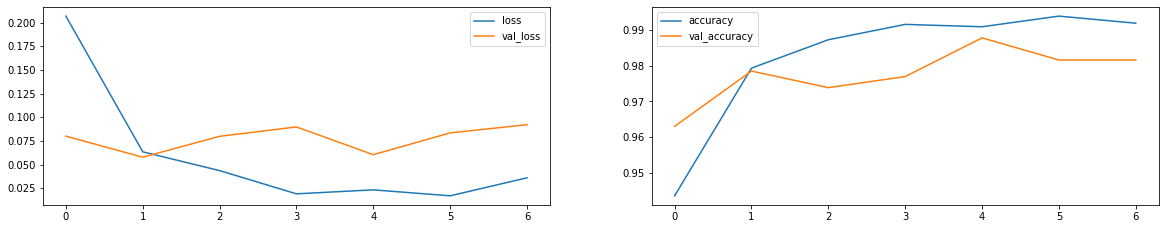

In [63]:
plt.figure(figsize=(20,8))

plt.subplot(2,2,1)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.subplot(2,2,2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

plt.show()

In [64]:
test_loss, test_accuracy = model.evaluate(test_data_gen, steps=ceil(test_size/BATCH_SIZE))

21/21 [==============================] - 8s 397ms/step - loss: 0.0908 - accuracy: 0.9725


In [65]:
test_labels = test_data_gen.classes
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [66]:
predict_prob = model.predict(test_data_gen, steps=ceil(test_size/BATCH_SIZE))
predictions = predict_prob.argmax(axis=-1)
predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [67]:
print(classification_report(test_labels, predictions, target_names=image_labels))
print('f1-score-overall   {:.2f}'.format(f1_score(test_labels, predictions, average='micro')))

              precision    recall  f1-score   support

   buildings       0.97      0.99      0.98       131
    entrance       0.98      0.98      0.98       131
  flat_plans       1.00      1.00      1.00       131
    interior       0.95      0.94      0.95       131
     windows       0.95      0.95      0.95       131

    accuracy                           0.97       655
   macro avg       0.97      0.97      0.97       655
weighted avg       0.97      0.97      0.97       655

f1-score-overall   0.97


In [68]:
test_data_gen[0][1][2].argmax(axis=0)

0

In [69]:
import random

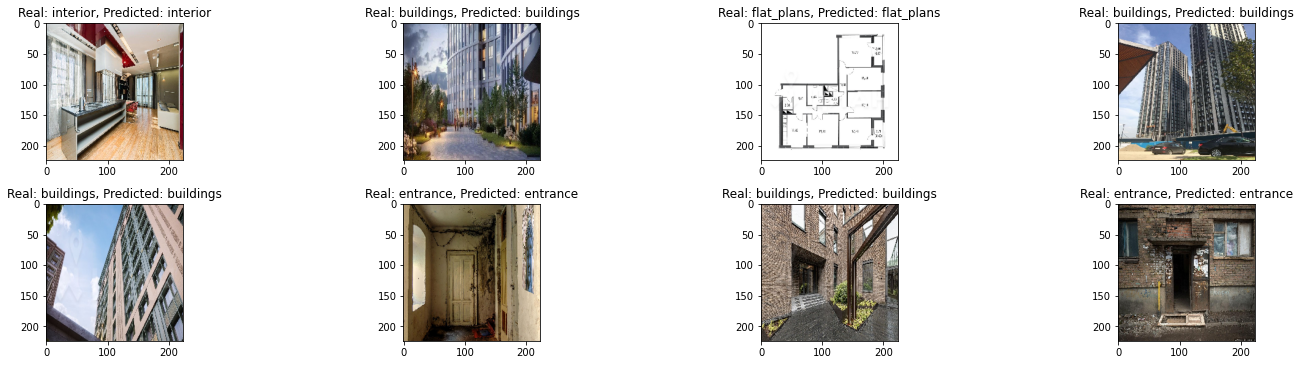

In [77]:
plt.figure(figsize=(20,20))

for i in range(8):

    index_batch = random.randint(0, 15)
    index_img = random.randint(0, 15)

    index_label_real = test_data_gen[index_batch][1][index_img].argmax(axis=0)
    img = test_data_gen[index_batch][0][index_img]

    plt.subplot(8, 4, i+1)
    plt.imshow(img)
    index_predicted_label = predictions[BATCH_SIZE * (index_batch + 1) + index_img]

    plt.title('Real: {}, Predicted: {}'.format(list(image_labels)[index_label_real], list(image_labels)[index_predicted_label]))

plt.tight_layout()

In [71]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
tflite_model_file = 'model.tflite'

with open(tflite_model_file, "wb") as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpkvrhozws/assets


INFO:tensorflow:Assets written to: /tmp/tmpkvrhozws/assets


In [72]:
def load_and_preprocessing(img_path):
  img_raw = tf.io.read_file(img_path)
  img_tensor = tf.image.decode_image(img_raw)
  img_final = tf.image.resize(img_tensor, (INPUT_SIZE, INPUT_SIZE)) / 255
  img_final = np.expand_dims(img_final, axis=0)
  return img_final

In [90]:
img_path = '/content/sample_data/new_test/interior1.jpg'
img = load_and_preprocessing(img_path)

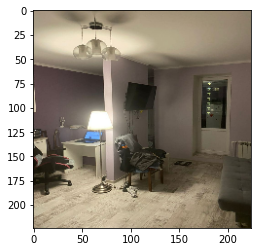

In [91]:
plt.imshow(img[0])

In [92]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_index = interpreter.get_input_details()[0]['index']
output_index = interpreter.get_output_details()[0]['index']

interpreter.set_tensor(input_index, img)
interpreter.invoke()
image_labels[interpreter.get_tensor(output_index).argmax(axis=1)[0]]

'interior'